<a href="https://colab.research.google.com/github/brainer3220/COVID19_Forecast/blob/master/corona19_confirmed_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
 
import numpy as np

# Load Dataset

In [2]:
# Confirmation, recovery, and death data sets by region worldwide
# 전세계 지역별 확진자, 회복자, 사망자 Data Set
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(url, error_bad_lines=False)

# Understanding the structure of the data set
# Data Set의 구조 파악
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,117158,118659,120216,120216,120216,120216,125937,127464,129021,130113,131586,131586,131586,134653,134653,136643,137853,137853,137853,137853,141489,142414,142414,143183,143439,143439,143439,144285,145008,145552,145996,146523,146523,146523,147985,148572,148933,149361,149810,149810
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,132514,132521,132523,132526,132534,132535,132537,132544,132557,132565,132580,132587,132592,132597,132608,132616,132629,132647,132665,132686,132697,132740,132763,132797,132828,132853,132875,132891,132922,132952,132999,133036,133081,133121,133146,133211,133310,133442,133591,133730
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,139229,139626,140075,140550,141007,141471,141966,142447,143032,143652,144483,145296,146064,146942,147883,148797,149906,151103,152210,153309,154486,155784,157005,158213,159563,160868,162155,163660,165204,167131,168668,170189,171392,172564,173922,175229,176724,178013,179216,180356
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13900,13911,13918,13918,13918,13918,13918,13991,14021,14050,14075,14075,14075,14155,14167,14167,14239,14273,14273,14273,14359,14379,14379,14464,14498,14498,14498,14577,14586,14586,14655,14678,14678,14678,14747,14766,14797,14809,14836,14836
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38682,38849,38965,39089,39172,39230,39300,39375,39491,39593,39791,39881,39958,40055,40138,40327,40530,40631,40707,40805,40906,41061,41227,41405,41629,41736,41780,41879,42110,42288,42486,42646,42777,42815,42970,43070,43158,43269,43487,43592


# Make it Simple

In [3]:
# Make Korea's confirmed cases timeseries dataframe
# 한국의 확진자 시계열 데이터프레임를 확인합니다

df_korea = data[data['Country/Region'] == 'Korea, South']
df_korea = df_korea.T[4:]

df_korea = df_korea.reset_index().rename(columns={'index': 'date', 160: 'confirmed'})

df_korea.tail()

,date,confirmed
559,8/3/21,203926
560,8/4/21,205702
561,8/5/21,207406
562,8/6/21,209228
563,8/7/21,210956


# Plot

In [4]:
# Plot Korean COVID19 confirmed cases.
# 한국 코로나19 확진자 트렌드를 그래프로 만듭니다.

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

fig

# Facebook Prophet

In [5]:
# Make dataframe for Facebook Prophet prediction model.
# Facebook Prophet 예측 모델에 넣을 데이터프레임을 만들어줍니다.
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

,ds,y
559,8/3/21,203926
560,8/4/21,205702
561,8/5/21,207406
562,8/6/21,209228
563,8/7/21,210956


# Create a Model

# Add changepoints to Make More Flexible
- https://facebook.github.io/prophet/docs/trend_changepoints.html

In [6]:
# Make Prophet model including daily seasonality
# Prophet에서 감안할 계절성을 선택해서 모델을 만듭니다
m = Prophet(
    changepoint_prior_scale=0.5, # increasing it will make the trend more flexible
    changepoint_range=0.95, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Plot changepoints

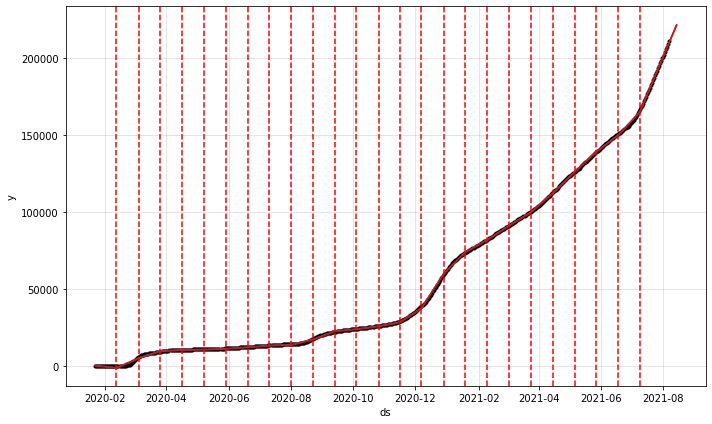

In [7]:
# display changepoints as red dotted line on the plot.
# changepoint를 그래프에 반영해봅시다.
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [8]:
day_confirmed = pd.DataFrame(np.array(df_korea.confirmed) - np.array(pd.concat([pd.DataFrame([0]), df_korea.confirmed[:-1]])).reshape(-1))
day_confirmed.columns = ["y"]

ds = df_prophet['ds']
day_confirmed = pd.concat([ds, day_confirmed], axis=1)
day_confirmed

,ds,y
0,1/22/20,1
1,1/23/20,0
2,1/24/20,1
3,1/25/20,0
4,1/26/20,1
...,...,...
559,8/3/21,1723
560,8/4/21,1776
561,8/5/21,1704
562,8/6/21,1822


In [9]:
# day_confirmed = pd.DataFrame(np.array(df_korea.confirmed) - np.array(pd.concat([pd.DataFrame([0]), df_korea.confirmed[:-1]])).reshape(-1))


m = Prophet(
    changepoint_prior_scale=0.6, # increasing it will make the trend more flexible
    changepoint_range=0.97, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

m.fit(day_confirmed)

future = m.make_future_dataframe(periods=31)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

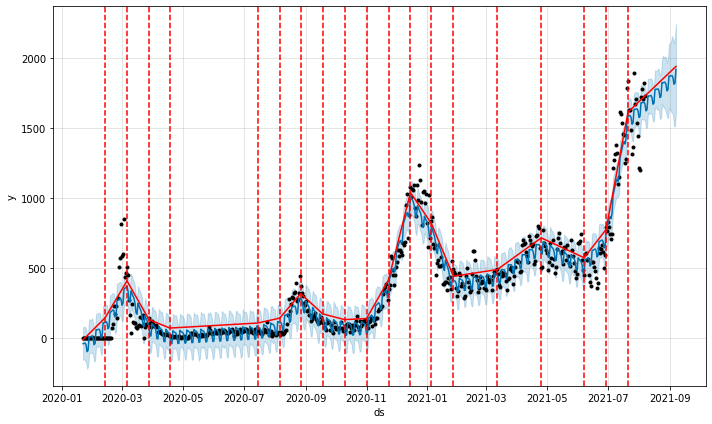

In [10]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)